## Word Association Analysis

In this notebook we will analyse a set of words scraped from ten online word association games. The word association game (WAG) is a popular forum game that can be found on message boards around the world. The aims of this analysis are getting more experience with data science (including but not limited to using jupyter notebooks, github, scraping, text mining, EDA and statistics) and obtaining more insight into the physological/neurological aspects of word associations. 

First, let's load the raw data set. Each row in the dataset contains two words, of which word2 is the assocation given by the (anonymized) author as a response to word1. The associations are scraped from 10 different sources, both given by the abbreviation of the forum name and an integer code (don't ask me why).

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting
import seaborn as sns # data visualization

df = pd.read_csv('../data/processed/wordgame_20180814.csv') # 
df.head(8)

,author,word1,word2,source,sourceID
0,6204,"Hmm... ""Let them eat cake""\n, \n, Link! , , \...",^^^^^ fail (too much extra chit chat didnt kno...,WP,9
1,1765,Haircut.,Scalp,GOG,4
2,3569,inflamed,Fire,SAS,6
3,1329,symptoms,goody,GOG,4
4,4800,that hold me inside,I want to reach out.............,U2,8
5,1442,yeah,generic,GOG,4
6,5112,bullies,PKs,WP,9
7,6204,momentum,motion sickness,WP,9


The data was collected (using scrapy) more than a year prior to writing this. Also, I did not have any prior experience with webscraping at that time. Thus re-scraping the data might be a good idea. It will also result in more data because most WAGs are still active. However, for now I will continue to work with this dataset.  

In [100]:
df.shape

(342267, 5)

We have as much as 0.3M word associations. Now, let's look at where I found all this data. 

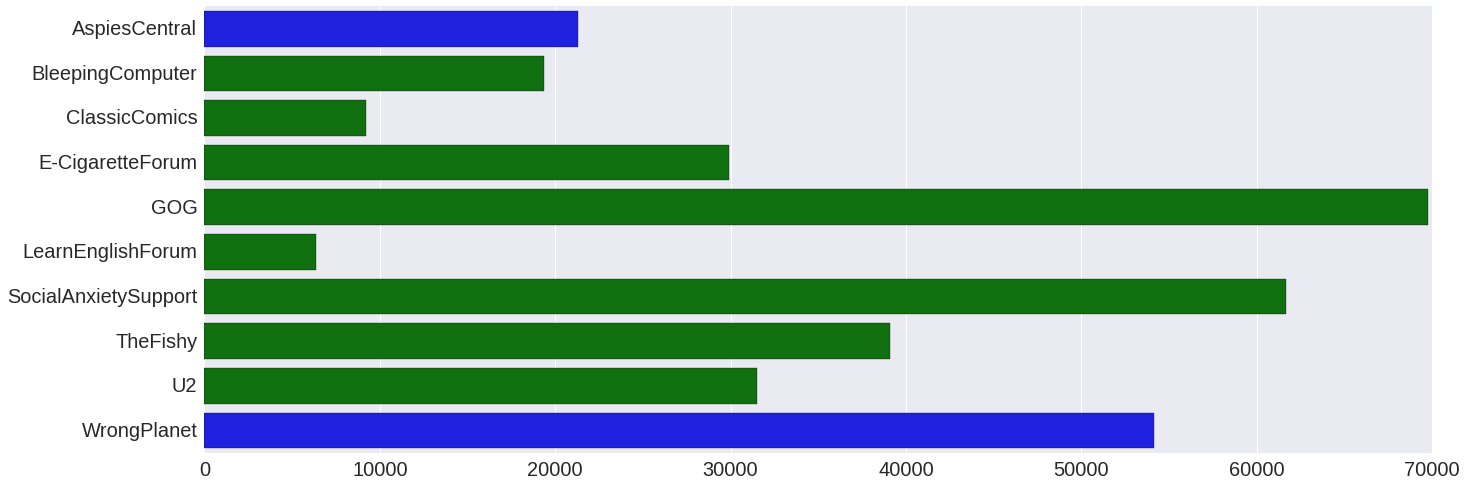

In [3]:
sources_names = ["AspiesCentral", "BleepingComputer", "ClassicComics","E-CigaretteForum","GOG","LearnEnglishForum","SocialAnxietySupport","TheFishy","U2","WrongPlanet"] 
clrs = ['blue','green','green','green','green','green','green','green','green','blue']

# use a bigger fontsize   
sns.set(font_scale=2.0)

plt.figure(figsize=(22, 8))
freq = df.source.value_counts().sort_index()
sns.barplot(freq.tolist(), sources_names, orient="h", palette=clrs)
#plt.title(sources_list[i])
plt.xlabel('')
plt.ylabel('')
plt.show()

I started with scraping AspiesCentral and WrongPlanet, which are both communities for people with autism. Other sources were simply found by an online search for large communities with big WAG topics. Although all data is in English, the sources are extremely diverse; ranging from British football supporters (TheFishy) to non-native English speakers (LearnEnglishForum). Sometimes the participants were strictly following the games' rules, but more often the data is really messy. So if you want to practice your data cleaning skills, you have found the perfect data set ;) Also, keep reading if you're more interested in things like classifation (autistic people vs. neuro-typicals?) ...

But before we go on to that, there is still something very important we have to look at first. If you know something about statistics you probably know the importance of a balanced experiment setup. Preferably, we have an equal amount of data from each source (but we already know that we do not have that) and each author should have roughly an equal amount of posts. Let's see whether thats assumption is valid. 

In [4]:
print("Number of authors: " + str(len(df.author.unique())))
print("Optimal number of posts/author: " + str(len(df)/len(df.author.unique())))
authors = df.author.value_counts() # list of authors sorted by their number of posts
print("Median number of posts/author: " + str(authors.median()))
print("Maximum number of posts/author: " + str(authors.max()) + " (" + str(round((authors.max()/authors.sum()*100),1)) + "%)") 

Number of authors: 6386
Optimal number of posts/author: 53.596461008456
Median number of posts/author: 3.0
Maximum number of posts/author: 12209 (3.6%)


It's not. The data is extremely skewed. Some authors are almost addicted to their word association game. One person alone accounts for 3.6% of all data (12209 posts!), whereas approximately 54 posts per author would be optimal. Can we fix this? 

Maximum number of posts/author: 703 (0.41%)
Number of posts left: 172090


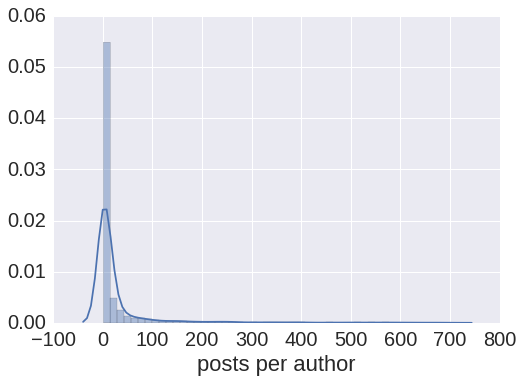

In [5]:
authors = df.author.value_counts() # list of authors sorted by their number of posts
authors = authors[99:] # remove 100 most active authors 
print("Maximum number of posts/author: " + str(authors.max()) + " (" + str(round((authors.max()/authors.sum()*100),2)) + "%)") 
print("Number of posts left: " + str(authors.sum()))
sns.distplot(authors)
plt.xlabel('posts per author')

Even when we would remove the 100 most WAG addicted authors (as shown in the plot above) and accept that we loose 50% of all data (in other words: 50% of all data comes from only 100 people!), the distribution of authors is still very skewed. Therefore, I decided to keep all data from all authors in the dataset, but keep in mind that this problem can have a huge influence on the results of this analysis. 

It's really time to start cleaning now... 

## Data cleaning
The script below shows how I removed unwanted interpunction (e.g. "...", "xD") and similar noise. The aim was to end up with mostly dictionary words, but without loosing to much valuable information. Choices were made by trail-and-error whilst keeping track of the amount of data lost. 

In [6]:
import re # for regular expressions

df['word1'] = df['word1'].astype(str) # converts floats to strings
df['word2'] = df['word2'].astype(str)

def toAscii(s):
	return bytes(s, 'utf-8').decode('ascii','ignore')

def preprocess(x):
	#replace..
	x = x.replace('\n',' ') # (wrongplanet)
	x = x.replace('_','')
	x = x.replace("`", "'")
	x = x.replace("~", "")
	x = x.replace("^", "")
	x = x.replace("$$", "$") #allows $-signs but not multiple
	x = re.sub("xd", "", x, flags=re.I) # removes xD/XD/xd etc.. 

	#remove everything following...
	x = x.split("Quote:")[0] # removes posts containing quotes from SAS
	x = x.split("Sent from my")[0] # removes mobile Tapatalk message (SAS)
	x = x.split("Edited by")[0] # bleeping_computer: additional post info was scraped
	x = x.split("Posted via")[0] #sas
	if(x.find("said:") > 1): x = '' #classic comics: removes posts containing quotes
	x = x.split("/")[0]
	x = x.split("(")[0]
	x = x.split(",")[0]
	x = x.split("*")[0]
	x = x.split("\u00a0")[0]
	x = x.split("--")[0]
	x = x.split("*")[0]
	x = x.split('"')[0]
	x = x.split(".")[0]
	x = x.split("!")[0]
	x = x.split("?")[0]
	x = x.split("=")[0]
	x = x.split("[")[0]
	x = x.split("{")[0]
	x = x.split(":")[0]
	x = x.split(";")[0]
	x = x.split(">")[0]
	x = x.split("<")[0] # deals with <comments> and <333 

	#remove leading characters
	x = x.lstrip("+")
	x = x.lstrip("-")
	x = x.lstrip("&")
	x = x.lstrip("'")
	x = x.lstrip(' ')

	#remove trailing characters		
	x = x.rstrip('-M') # crazy 'signature' by a person with many posts..
	x = x.rstrip("'")
	x = x.rstrip(' ')
	x = x.rstrip('\u00a0') # removes trailing non-breaking spaces (the fishy)
	
	return x

# delete all words containing non-ascii characters
df['word1'] = df['word1'].apply(lambda x: toAscii(x))
df['word2'] = df['word2'].apply(lambda x: toAscii(x))

# clean data
df['word1'] = df['word1'].apply(lambda x: preprocess(x))
df['word2'] = df['word2'].apply(lambda x: preprocess(x))

#convert all to lowercase
df['word1'] = df['word1'].apply(lambda x: x.lower())
df['word2'] = df['word2'].apply(lambda x: x.lower())

df = df.replace('',np.NaN)

# compute fraction NaN values
#print(df['word1'].isnull().sum()/len(df))
#print(df['word2'].isnull().sum()/len(df))

# drop all pairs containing NaN values
df = df.dropna(axis=0, how='any').reset_index(drop=True)

In [7]:
df.head(8)

,author,word1,word2,source,sourceID
0,6204,hmm,fail,WP,9
1,1765,haircut,scalp,GOG,4
2,3569,inflamed,fire,SAS,6
3,1329,symptoms,goody,GOG,4
4,4800,that hold me inside,i want to reach out,U2,8
5,1442,yeah,generic,GOG,4
6,5112,bullies,pks,WP,9
7,6204,momentum,motion sickness,WP,9


That looks better, right? 

Additionally, some word pairs consist of two identical words. This is possibly the result of quoting the post of the previous author combined with incorrect scraping/data cleaning or it was done on purpose. Either way, I will not result in useful insights about word associations. We remove these pairs below. 

In [8]:
df['equal'] = df.apply(lambda x: str(x.word1)==str(x.word2), axis=1)
pairs = df['equal'].sum()
df = df[df['equal']==False] 
df = df.drop('equal', 1) # delete equal column
print(str(pairs) + " identical pairs have been removed") # number of pairs where word1==word2

574 pairs will be removed


In [9]:
## save cleaned/preprocessed data
df.to_csv("../data/processed/wordgame_20180816_pr.csv", sep=',', index=False)

## Words!
Now we completed the data cleaning it is finally time to look at some words! Which words are the most frequently on our mind? I had really no idea about this before I did this analysis. 

In [10]:
# compute term frequency (TF) feature
df['tf'] = df.groupby(['word2'])['word2'].transform('count')

frequent_words = df.drop_duplicates(subset=['word2']).sort_values(by=['tf'], ascending=False).head(10)
frequent_words[['word2','tf']] # or simply use value_counts() ... 

,word2,tf
793,water,647
1821,time,536
53,music,534
164,love,458
1848,money,453
2,fire,446
218,food,437
244,game,406
2157,house,405
94,dog,405


I must agree that most of these things are also pretty important for me too. Especially food, water and my dog. ;)

Note that due to the nature of the game each word is both an association as a cue for the next participant. As a result the list of word1's is roughly\* similar to the list of word2's. This is why I only computed the frequencies of word2 (using word1 instead would have given the same results). 

\*data cleaning did remove some rows.

The same analysis is possible for pairs instead of words. Which word pairs are the most frequent? 

In [11]:
df['pair'] = df.apply(lambda x: str(x.word1) + ":" + str(x.word2), axis=1)
df['pf'] = df.groupby(['pair'])['pair'].transform('count')
df.pair.value_counts().head(11)

me:you         85
man:woman      66
up:down        64
time:clock     63
green:grass    52
house:home     49
dog:cat        49
lost:found     48
out:in         45
life:death     44
down:under     44
Name: pair, dtype: int64

Again I was really surprised that some associations are much more frequent than others (me->you is 85 times in the dataset!). 

Talking about frequencies, we can also plot the term frequency of the words against their frequency rank. According to Zipf law, the frequency of any word (in a large sample of words) is inversely proportional to its rank in the frequency.

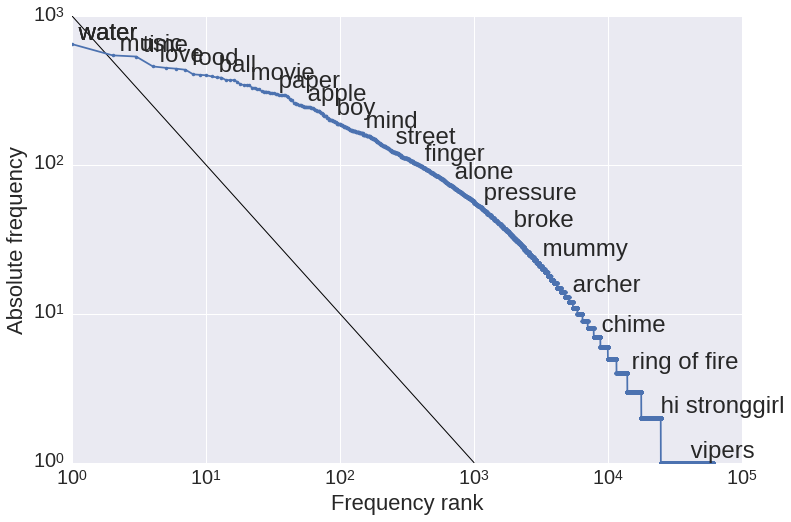

In [20]:
counts = np.array(df.word1.value_counts())
tokens = np.array(df.word1.value_counts().index)
ranks = np.arange(1, len(counts)+1)
indices = np.argsort(-counts)
frequencies = counts[indices]

plt.figure(figsize=(12, 8))
plt.plot([1, 10e2], [10e2, 1], color='k', linestyle='-', linewidth=1) # adds a diagonal line to the plot
plt.loglog(ranks, frequencies, marker=".")
for n in list(np.logspace(-0.5, np.log10(len(counts)), 25).astype(int))[:-1]:
    dummy = plt.text(ranks[n], frequencies[n], " " + tokens[indices[n]], verticalalignment="bottom", horizontalalignment="left")
plt.xlabel("Frequency rank")
plt.ylabel("Absolute frequency")
plt.grid(True)
plt.show()

It seems that the law does not apply for word association data.

## Feature Extraction
Time to get serious now. We can't call this text mining without some sort of feature extraction, right? We already have the term frequency, but we can extract MUCH more information from this dataset. We're starting with the syntactic features. 

## Syntactic Features
### Word length

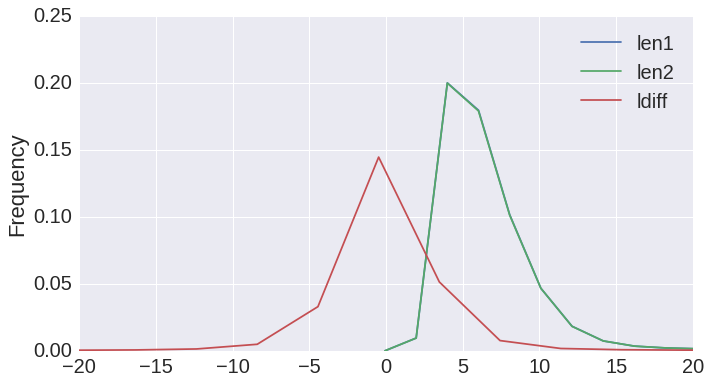

In [21]:
df['len1'] = df['word1'].apply(lambda x:len(x))
df['len2'] = df['word2'].apply(lambda x:len(x))
df['ldiff'] = df['len1'] - df['len2'] # length difference between word1 and word2 

# plots the length features (because I like plots ...)
plt.figure(figsize=(11, 6))
f = sns.kdeplot(df['len1'])  
g = sns.kdeplot(df['len2'])  
h = sns.kdeplot(df['ldiff'])  
#plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
axes = plt.gca()
axes.set_xlim([-20,20])
plt.show()

Most strings have length 4 and often both words have an equal length.

### Prefices and Suffices
Looking at the word pairs again, do they have a common prefix or suffix? And what is the length of this prefix/suffix? This might seem useless, but I found many syntactic associations (eg. bowels->vowels) in the dataset. (In my opinion this is not how the game should be played, but strictly speaking syntactic associations are still associations...).

In [23]:
import os
df['prefix'] = df.apply(lambda r: os.path.commonprefix([r.word1, r.word2]), axis=1)
df['pl']= (df['prefix'].apply(lambda x: len(x)))
df['suffix'] = df.apply(lambda r: os.path.commonprefix([r.word1[::-1], r.word2[::-1]]), axis=1)
df['suffix'] = df['suffix'].apply(lambda x:x[::-1]) #re-reverse suffix
df['sl']= (df['suffix'].apply(lambda x: len(x)))

print("Most frequent common prefices: " + str(df.prefix.value_counts().head(10).index))
print("Most frequent common suffices: " + str(df.suffix.value_counts().head(10).index))

Most frequent common prefices: Index(['', 's', 'c', 'b', 'p', 'm', 'f', 't', 'd', 'a'], dtype='object')
Most frequent common suffices: Index(['', 'e', 's', 't', 'y', 'n', 'ed', 'er', 'ing', 'r'], dtype='object')


Nothing unexpected here... 

### Levenstein Distance

Levenshtein distance (also called Edit Distance) is a measure of the similarity between two strings. It is minimum the number of deletions, insertions, or substitutions required to transform the first string into the second.

In [21]:
import Levenshtein
def levenshtein(r): #calculates levenstein distance
	return Levenshtein.distance(r.word1, r.word2)

df['edit'] = df.apply(levenshtein, axis=1)

Just for fun, here are some random word pairs from the dataset with edit distance=1.

In [25]:
df[['pair','edit']].drop_duplicates(subset=['pair']).sort_values(by=['edit'], ascending=True).head(10)

,pair,edit
151339,theses:theseus,1
90216,f:c,1
282361,toes:poes,1
282357,massage:message,1
166523,tight:tights,1
90287,silicone:silicon,1
90289,wind:wing,1
282218,laughter:slaughter,1
90294,light:tight,1
282174,wiggle:jiggle,1


This concludes the syntactic feature extraction. In the next section we move on to the semantic features such as word similarity. :)

## Semantic Features
Although we did extract some information using the syntactic approach, in most cases basic features such as word length and edit distance will not explain why someone has a specific association by any given cue. We still lack knowledge about the meaning of these words. When looking at the data yourself it was probably very easy to understand the word pairs (I must admit that I googled some curious word pairs ...). However, for a computer this is a very challenging task. 

Luckily we do not have to start from scratch with this. Some smart people from Google have created Word2Vec embeddings that can be used to compute the similarity of two words. Furthermore, an NLTK wordnet can be used to identify nouns, synonyms, antonyms, hypernyms, hyponyms, and so on.  

### Word2Vec
Let's start with Word2Vec. We load the pre-trained Google News corpus word vector model (source: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit).

In [26]:
from gensim.models.keyedvectors import KeyedVectors
# this might take a while, and requires a computer with a decent amount of memory (16+ GB)
w2v_model = KeyedVectors.load_word2vec_format('../data/external/GoogleNews-vectors-negative300.bin', binary=True)
print('Loaded word embeddings')

Loaded word embeddings


This model is case sensitive (e.g. 'France' and 'france' each have different word vectors). Furthermore, all spaces within tokens are replaced by underscores. 

In [31]:
#df['word1w2v'] = df.word1.apply(lambda x:(x.replace(" ", "_"))) # the example -> the_example (word2vec convention)
#df['inw2v1'] = df['word1w2v'].apply(lambda x:(x in w2v_model.vocab))
#print(df[df.inw2v1==False].head(10).word1w2v.tolist())
print("Percentage of list in word2vec vocabulary (word1):" + str(round(df.inw2v1.sum()/len(df)*100,1)))

Percentage of list in word2vec vocabulary (word1):89.5


During data cleaning we converted all words to lowercase, because of the inconsistent capitalization among different authors and sources (e.g. water, Water, WATER and wAtEr) which would lead to incorrect term frequencies and other problems.

However, correct capitalization is (in some cases) necessary to find the word in the the word2vec vocabulary. Therefore, we also apply title capitalization to the words that did not match the word2vec vocubulary and search for the word again. When this also does not return a vocabulary hit, we convert the word to uppercase and search once more. 

In [32]:
df.ix[~df.inw2v1, 'word1w2v'] = df.ix[~df.inw2v1].word1w2v.apply(lambda x:x.title()) # the_example -> The_Example
df['inw2v1'] = df['word1w2v'].apply(lambda x:(x in w2v_model.vocab))
df.ix[~df.inw2v1, 'word1w2v'] = df.ix[~df.inw2v1].word1w2v.apply(lambda x:x.upper())
df['inw2v1'] = df['word1w2v'].apply(lambda x:(x in w2v_model.vocab))
print("Percentage of list in word2vec vocabulary (word1): " + str(round(df.inw2v1.sum()/len(df)*100,1)))

Percentage of list in word2vec vocabulary (word1):93.5


This approach resulted in an increase of 4% in vocabulary hits for word1. Below we also apply it to word2 and compute the number of pairs of which both words were found in the word2vec model. 

In [33]:
df['word2w2v'] = df.word2.apply(lambda x:(x.replace(" ", "_"))) # the example -> the_example
df['inw2v2'] = df['word2w2v'].apply(lambda x:(x in w2v_model.vocab)) 
df.ix[~df.inw2v2, 'word2w2v'] = df.ix[~df.inw2v2].word2.apply(lambda x:x.title()) # the_example -> The_Example
df['inw2v2'] = df['word2w2v'].apply(lambda x:(x in w2v_model.vocab))
df.ix[~df.inw2v2, 'word2w2v'] = df.ix[~df.inw2v2].word2.apply(lambda x:x.upper()) # The_Example -> THE_EXAMPLE
df['inw2v2'] = df['word2w2v'].apply(lambda x:(x in w2v_model.vocab))

df['inw2v'] = df.apply(lambda r:(r.inw2v1 & r.inw2v2), axis=1)
df = df.drop('inw2v1', 1)
df = df.drop('inw2v2', 1)

print("Percentage of pairs found word2vec vocabulary (word1 AND word2): " + str(round(df.inw2v.sum()/len(df)*100,1)))

Percentage of pairs found word2vec vocabulary (word1 AND word2): 87.4


I think that's not a bad result given the highly informal nature of the word association games. Just to check the validity of the artificial (re-)capitalization, let's look at some word pairs for which capitalization resulted in a dictionary hit.  

In [35]:
dfwords = df[(((df.word1 != df.word1w2v) | (df.word2!=df.word2w2v)) & df.inw2v)]
print("Corrected pairs: " + str(len(dfwords)))
dfwords[['word1','word2','word1w2v', 'word2w2v']].head(5)

Corrected pairs: 19417


,word1,word2,word1w2v,word2w2v
6,bullies,pks,bullies,PKS
7,momentum,motion sickness,momentum,motion_sickness
27,mangos,malesia,mangos,Malesia
43,rna,rng,RNA,RNG
58,pythagoras,theory,Pythagoras,theory


And here are some word pairs that are still not recognized by the model:

In [39]:
dfnotwords = df[~df.inw2v]
print("Pairs with unknown words: " + str(len(dfnotwords)))
dfnotwords[['word1','word2','word1w2v', 'word2w2v']].head(5)

Pairs with unknown words: 41860


,word1,word2,word1w2v,word2w2v
4,that hold me inside,i want to reach out,THAT_HOLD_ME_INSIDE,I WANT TO REACH OUT
21,link,knurls,link,KNURLS
25,team rocket,pokmon,TEAM_ROCKET,Pokmon
36,shapes,love heart,shapes,LOVE HEART
55,s t r e t c h,jail,S_T_R_E_T_C_H,jail


Well, we can't blame Google for not knowing all U2 lyrics, incorrectly spelled words (Pokmon) or for words spelled like t h i s ! Wait... I seems that Pokmon actually is a word in the Word2Vec model, but Team Rocket is not.

Finally, we can compute the similarity for all other word pairs.

In [40]:
df['sim'] = np.nan # similarity for unknown word pairs
df.ix[df.inw2v, 'sim'] = df.ix[df.inw2v].apply(lambda r:w2v_model.similarity(r.word1w2v, r.word2w2v), axis=1)

I'll show you some word pairs with highly similar words (according to Google) below. 

In [41]:
df[['pair','sim']].drop_duplicates(subset=['pair']).sort_values(by=['sim'], ascending=False).head(5)

,pair,sim
39307,three:four,0.970343
207751,four:three,0.970343
22226,south:north,0.967454
2488,north:south,0.967454
38208,west:east,0.965323


And a plot of the similarity distributions... 

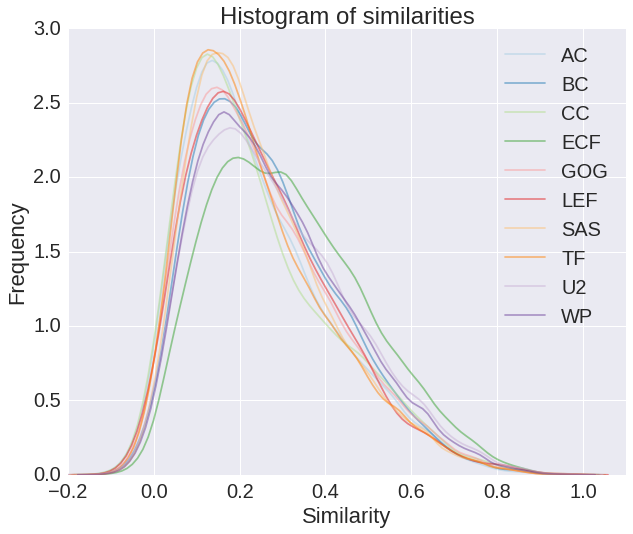

In [43]:
w2vdf = df[df.inw2v==True] # only keep pairs with similarity scores

pal = sns.color_palette("Paired", 10)
plt.figure(figsize=(22, 8))
plt.subplot(1,2,1)
for i in range(0,10,1):
    s = w2vdf[w2vdf['sourceID']==i]
    #print(s.sim.mean())
    sns.kdeplot(s['sim'], alpha=0.5, label=s.iloc[0]['source'], color=pal[i])  
plt.title('Histogram of similarities')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
axes = plt.gca()
axes.set_xlim([-0.2,1.1])

plt.show()

The word pairs from the E-Cigarette Forum (ECF) seem to have the highest similarities on average. Negative similarities are rare, but also possible. (Read about cosine similarity if you're interested in the mathematics behind the Word2Vec similarities)

Additionally I also wanted to plot some of the word vectors. It is not possible to plot these directly, because each word is represented as a 300 dimensional vector (have you ever seen a 300-D plot?), but using other algorithms (eg. t-SNE) we can reduce the number of dimensions.

First, I plot all assocations for cues "life" and "death" in a 2D scatterplot. Frequent assocations (with frequency > 5) are annotated. Similarly, the associations for cues "food" and "chocolate" are plotted. Note: The t-SNE algorithm has a random component, so setting a different random seed value can result in completely different plots.

In [45]:
from sklearn.manifold import TSNE

sampleA = w2vdf[(w2vdf['word1w2v'].isin(["death","life"]))][:] # select only pairs with word1=life||death
sampleA['wv2'] = sampleA['word2w2v'].apply(lambda x: w2v_model.word_vec(x)) # compute word vector
sampleA['c'] = sampleA.groupby(['word2w2v'])['word2w2v'].transform('count') # count duplicate pairs
#del w2v_model

In [46]:
model = TSNE(random_state=552).fit_transform(sampleA['wv2'].tolist()) # Compute reduced word-vectors
sampleA['x'] = model[:,0]
sampleA['y'] = model[:,1]

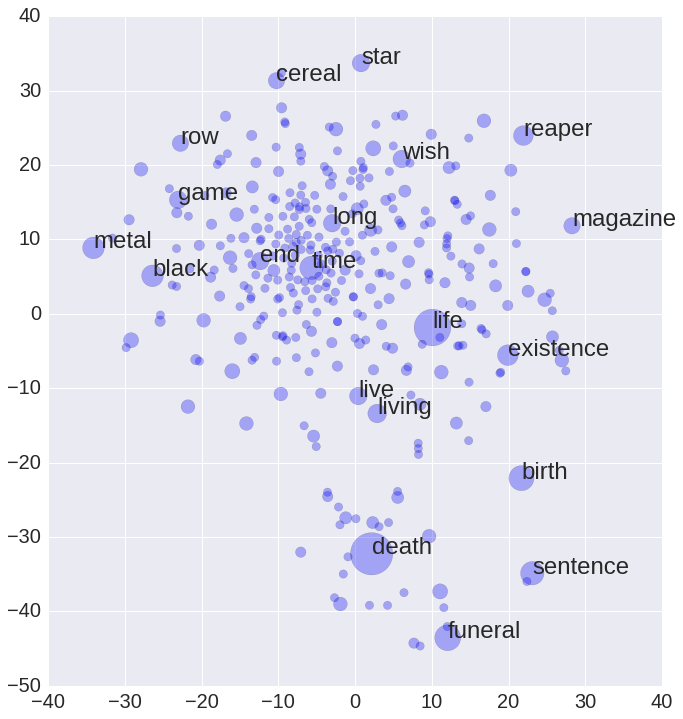

In [47]:
sampleA = sampleA.drop_duplicates(subset=['word2']) 
fig, ax = plt.subplots()
fig.set_figwidth(11)
fig.set_figheight(12)
ax.scatter(sampleA.x, sampleA.y, marker='o', s=30+40*sampleA.c, alpha=0.3)
for j in range(0,len(sampleA)):
    if(sampleA.c.iloc[j] > 5):
        ax.annotate(sampleA.word2.iloc[j], (sampleA.x.iloc[j], sampleA.y.iloc[j]))
plt.show()

In [49]:
sampleB = w2vdf[(w2vdf['word1w2v'].isin(["food","chocolate"]))][:] # select only pairs with word1=food||chocolate
sampleB['wv2'] = sampleB['word2w2v'].apply(lambda x: w2v_model.word_vec(x)) # compute word vector
sampleB['c'] = sampleB.groupby(['word2w2v'])['word2w2v'].transform('count') # count duplicate pairs

In [50]:
model = TSNE(random_state=23).fit_transform(sampleB['wv2'].tolist()) # Compute reduced word-vectors
sampleB['x'] = model[:,0]
sampleB['y'] = model[:,1]

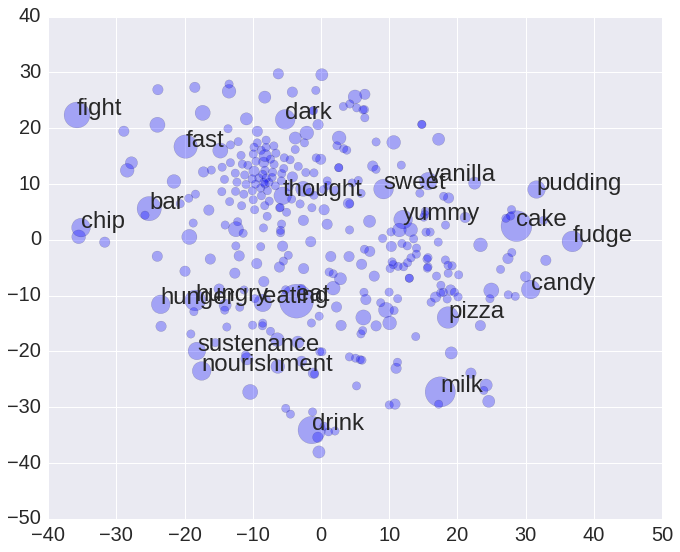

In [51]:
sampleB = sampleB.drop_duplicates(subset=['word2']) 
fig, ax = plt.subplots()
fig.set_figwidth(11)
fig.set_figheight(9)
ax.scatter(sampleB.x, sampleB.y, marker='o', s=30+40*sampleB.c, alpha=0.3)
for j in range(0,len(sampleB)):
    if(sampleB.c.iloc[j] > 5):
        ax.annotate(sampleB.word2.iloc[j], (sampleB.x.iloc[j], sampleB.y.iloc[j]))
plt.show()

### WordNet / NLTK
Besides Word2Vec there exist many other sources that can provide semantic information about words. An important source is WordNet, which is a lexical database for the English language, which was created by Princeton, and is part of the NLTK corpus. It can be used to classify words as nouns, verbs and more. Word pairs can be identified as synonyms, antonyms, hypernyms and hyponyms. 

In the code below we create (boolean) features for nouns, synonyms, antonyms, hypernyms and hypernyms (or at least that's what I attempted to do because I did not fully understand the ntlk.corpus package).

In [54]:
from itertools import chain
from nltk.corpus import wordnet

nouns = {x.name().split('.', 1)[0] for x in wordnet.all_synsets('n')} 
df['noun'] = df['word2'].apply(lambda x:(x in nouns)) 

In [55]:
def isSynonym(r):
    synonyms = wordnet.synsets(r.word1)
    lemmas = set(chain.from_iterable([w.lemma_names() for w in synonyms]))
    return (r.word2 in lemmas)

df['synonym'] = df.apply(isSynonym, axis=1)

In [56]:
def isAntonym(r):
    h = []
    for syn in wordnet.synsets(r.word1):
        for l in syn.lemmas():
            if l.antonyms():
                h.append(l.antonyms()[0].name().split('.')[0]) 
    return (r.word2 in h)

df['antonym'] = df.apply(isAntonym, axis=1)

Hyponymy shows the relationship between a generic term (hypernym) and a specific instance of it (hyponym).

In [57]:
def isHypernym(r):
    h = []
    for syn in wordnet.synsets(r.word1):
        if syn.hypernyms():
            h.append(syn.hypernyms()[0].name().split('.')[0])
    return (r.word2 in h)
df['hypernym'] = df.apply(isHypernym, axis=1)

In [58]:
def isHyponym(r):
    h = []
    for syn in wordnet.synsets(r.word1):
        if syn.hyponyms():
            h.append(syn.hyponyms()[0].name().split('.')[0]) 
    return (r.word2 in h)
df['hyponym'] = df.apply(isHyponym, axis=1)

In [65]:
dfsem = df[df.synonym | df.antonym | df.hypernym | df.hyponym]
print("Percentage of pairs with semantic relationship(s): " + str(round(len(dfsem)/len(df)*100,2)))
dfsem[['word1', 'word2', 'synonym', 'antonym', 'hypernym', 'hyponym']].head(5)

Percentage of pairs with semantic relationship(s): 6.76


,word1,word2,synonym,antonym,hypernym,hyponym
48,wound,hurt,True,False,True,False
80,grow,mature,True,False,False,False
84,hot,cold,False,True,False,False
111,resort,hotel,False,False,True,False
114,sweater,cardigan,False,False,False,True


Only a small percentage of the word pairs appear to have semantic relationships (or the WordNet did not return the correct results), but as can be expected synonyms are the most represented in the WAG data. 

## Psychological features
Last but not least we are going to enrich the data with some psychological and psycholinguistic features.

### Autism
We can assume that authors from AC and WP are more likely to have an autism spectrum disorder (ASD) and that authors from other sources are more likely not to have ASD (given that the current ASD prevalence estimate is < 2%). Still, it's a HUGE assumption to classify authors based on their presence in a specific online community, but I'm going to include this 'feature' anyways as it is the only additional information about the authors that we have. 

In [66]:
df['ASD'] = df['sourceID'].apply(lambda x:int((x%9)==0)) # 0= AspiesCentral, 9=WrongPlanet
print("Percentage of data from WP and AC: " + str(round(df.ASD.mean()*100,1)))

Percentage of data from WP and AC: 22.2


### Age-of-Acquisition
Age of Acquisition is a psycholinguistic variable referring to the age at which a word is typically learned. Source: http://crr.ugent.be/archives/806. 

In [6]:
import csv
reader = csv.reader(open('../data/external/AoA_ratings_Kuperman.csv', 'r'))

AoA = {} 
for k, v in reader: # read data from CSV in to python dictionary
    if(v != 'NA'):
       AoA[k] = v

df['AoA'] = df['word2'].apply(lambda x:float(AoA[x]) if x in AoA else np.nan) 
print("Percentage of words (word2) with known Age of Acquisition: " + str(round(len(df[~df['AoA'].isnull()])/len(df)*100,1)))
print("List of words with unkonwn AoA: \n")
df[df.AoA.isnull()].tail(20).word2.tolist()

Percentage of words (word2) with known Age of Acquisition: 71.9
List of words with unkonwn AoA: 



['lucifer',
 'canter',
 'candles',
 'mentat',
 'caddy',
 'splitting',
 'ardennes',
 'chewbacca',
 'swollow',
 'donut',
 'roleplay',
 'shoes',
 'toyota',
 'i',
 'rehearses',
 "it's 10 to 1 already",
 'epiphanies',
 'legs',
 'remote control',
 'theirs']

For only (roughly) 70 percent of the data the age of acquisition could be determined. Stemming or singularization of plurals (e.g. shoes, legs...) can be considered to improve this result. 

The distribution of AoA scores for each source is plotted below. 

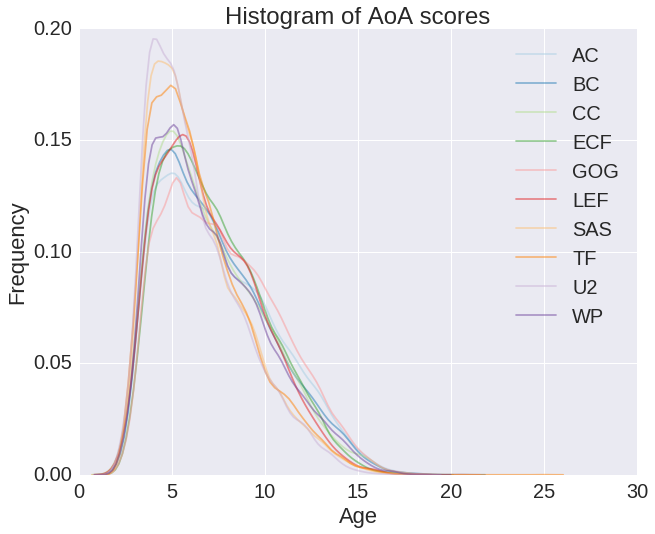

7.014058480313186

In [86]:
aoadf = df[~df.AoA.isnull()] # only keep pairs with aoa scores

pal = sns.color_palette("Paired", 10)
plt.figure(figsize=(22, 8))
plt.subplot(1,2,1)
for i in range(0,10,1):
    s = aoadf[aoadf['sourceID']==i]
    #print(s.sim.mean())
    sns.kdeplot(s['AoA'], alpha=0.5, label=s.iloc[0]['source'], color=pal[i])  
plt.title('Histogram of AoA scores')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
#axes = plt.gca()
#axes.set_xlim([-0.2,1.1])

plt.show()
aoadf.AoA.mean()

U2-fans (U2) are frequently using words with really low AoA scores, which might indicate that their average age is also lower compared to other sources. The same might apply to the people with with social anxiety (SAS) and the Brittish football fans (TF). Gamers (GOG), for example, tend use words that are learnt later in life. The distribution also shows that overall most words are learnt around the age of 7. 

## Concreteness rating
Another phycholinguistic variable is the concreteness rating. (source: http://crr.ugent.be/archives/1330) 

In [8]:
reader = csv.reader(open('../data/external/Concreteness_english.csv', 'r'))

Conc = {}
for k, v in reader:
    if(v != 'NA'):
       Conc[k] = v
df['CR'] = df['word2'].apply(lambda x:float(Conc[x]) if x in Conc else np.nan)
print("Percentage of words (word2) with known Concreteness Rating: " + str(round(len(df[~df['CR'].isnull()])/len(df)*100,1)))
df[['word2','CR']].head(8)

Percentage of words (word2) with known Concreteness Rating: 74.9
List of words with unkonwn CR: 



,word2,CR
0,fail,3.00
1,scalp,4.82
2,fire,4.68
3,goody,2.04
4,i want to reach out,NaN
5,generic,2.63
6,pks,NaN
7,motion sickness,3.66


Words like 'fire' have a high concreteness rating, whereas words like 'fail' and 'generic' have low concreteness ratings. 

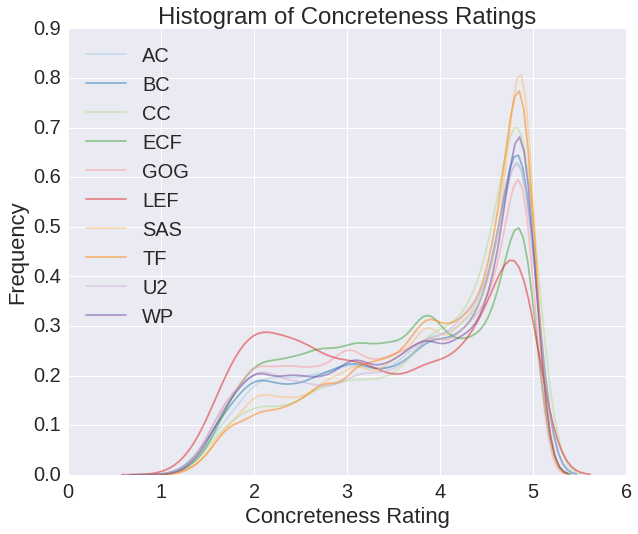

In [92]:
crdf = df[~df.CR.isnull()] # only keep pairs with aoa scores

pal = sns.color_palette("Paired", 10)
plt.figure(figsize=(22, 8))
plt.subplot(1,2,1)
for i in range(0,10,1):
    s = crdf[crdf['sourceID']==i]
    #print(s.sim.mean())
    sns.kdeplot(s['CR'], alpha=0.5, label=s.iloc[0]['source'], color=pal[i])  
plt.title('Histogram of Concreteness Ratings')
plt.xlabel('Concreteness Rating')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
#axes = plt.gca()
#axes.set_xlim([-0.2,1.1])
plt.show()

Interestingly, non-native English speakers (LEF: Learn English Forum) most frequently use words with low concreteness ratings and least frequently use words with high concreteness. (compared to the other sources). The opposite is true for authors from TF (The Fishy, a football club from England).

This concludes the feature extraction phase. We extracted 10 syntactical features, 6 semantic features and 3 psychological/psycholinguistic features. In the next phase we are going discover some relationships between these features. 

In [22]:
# save features
df.to_csv("../data/processed/wordgame_20180816_ft.csv", sep=',', index=False)
df = pd.read_csv('../data/processed/wordgame_20180816_ft.csv') # load saved data with features

## Correlation
The Pearson correlation coefficient is a measure of the linear correlation between two variables X and Y. It has a value between +1 and −1, where 1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation. 

291602


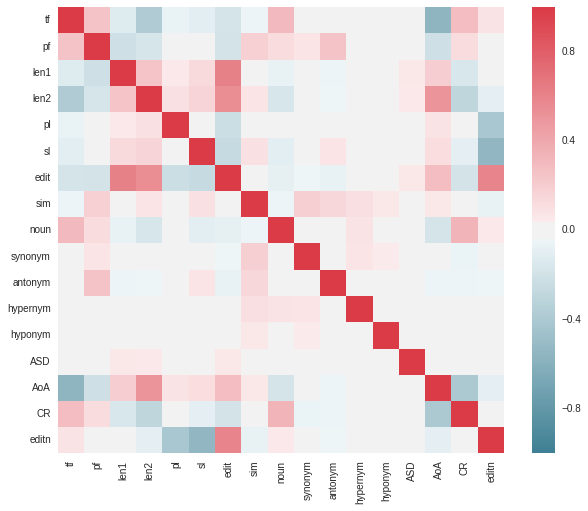

In [45]:
cordf = df
cordf = df[df.inw2v==True] # include only words pairs found in word2vec model
# removes columns for which we do not need correlation measures
cordf = cordf.drop('inw2v',1)
#cordf = cordf[~cordf.AoA.isnull()]
#cordf = cordf.drop('ASD',1)
cordf = cordf.drop('author',1)
#cordf = cordf.drop('len1',1)
cordf = cordf.drop('ldiff',1)
cordf = cordf.drop('sourceID',1)
print(len(cordf))

f, ax = plt.subplots(figsize=(10, 8))
corr = cordf.corr(method='pearson')
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

plt.show()

The first thing I noticed was the (high) positive correlation between the word length and the edit distance. To fix this we have to normalize the edit distance using the word lengths. 

In [46]:
df['editn'] = df.edit/((df.len1+df.len2)*0.5) # divides edit by average of both word lenghts. 
df[['pair','edit','editn']].sort_values(by=['edit'], ascending=False).tail(5)

,pair,edit,editn
16615,wine:vine,1,0.250000
91894,friend:fiend,1,0.181818
242503,revolution:devolution,1,0.100000
195455,fellow:mellow,1,0.166667
71000,gravel:grave,1,0.181818


All words pairs shown above have edit distance 1, but they all have different normalized edit distances. One edit can change 25% of a four letter word (e.g. wine->vine), while it only changes 10% percent in a 10-letter word (e.g. revolution->devolution). 



291602


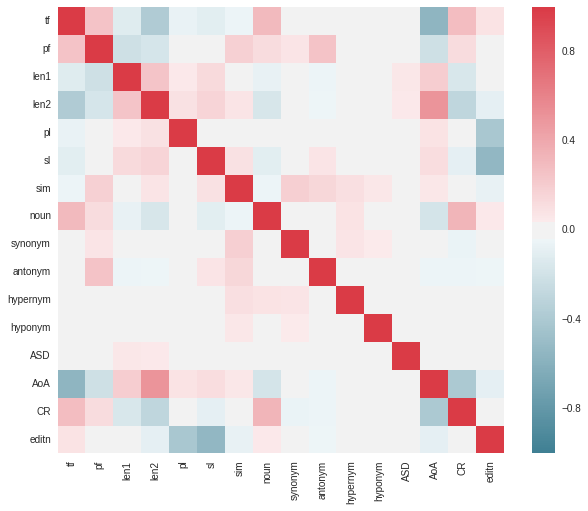

In [47]:
#cordf['AC'] = df['sourceID'].apply(lambda x:int(x==0)) # 0= AspiesCentral, 9=WrongPlanet
#cordf['BC'] = df['sourceID'].apply(lambda x:int(x==1)) # 0= AspiesCentral, 9=WrongPlanet
#cordf['CC'] = df['sourceID'].apply(lambda x:int(x==2)) # 0= AspiesCentral, 9=WrongPlanet
#cordf['ECF'] = df['sourceID'].apply(lambda x:int(x==3)) # 0= AspiesCentral, 9=WrongPlanet
#cordf['GOG'] = df['sourceID'].apply(lambda x:int(x==4)) # 0= AspiesCentral, 9=WrongPlanet
#cordf['LEF'] = df['sourceID'].apply(lambda x:int(x==5)) # 0= AspiesCentral, 9=WrongPlanet
#cordf['SAS'] = df['sourceID'].apply(lambda x:int(x==6)) # 0= AspiesCentral, 9=WrongPlanet
#cordf['TF'] = df['sourceID'].apply(lambda x:int(x==7)) # 0= AspiesCentral, 9=WrongPlanet
#cordf['U2'] = df['sourceID'].apply(lambda x:int(x==8)) # 0= AspiesCentral, 9=WrongPlanet
#cordf['WP'] = df['sourceID'].apply(lambda x:int(x==9)) # 0= AspiesCentral, 9=WrongPlanet

cordf['editn'] = cordf.edit/((cordf.len1+cordf.len2)*0.5) # normalize Edit Distance in correlation data
cordf = cordf.drop('edit',1)
print(len(cordf))

f, ax = plt.subplots(figsize=(10, 8))
corr = cordf.corr(method='pearson')
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

plt.show()